<a href="https://colab.research.google.com/github/NittyNice/BADS7105-CRM-Analytics/blob/main/Assignment-7_Voice%20of%20customer/Voice_of_customer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and config


## Mount google drive
Google Colab provides library to connect directly to Google Drive.  
Alternative way connection to the storage for loading and saving data files.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Use Linux command – <code>ls</code> to displays the contents of a directory.

In [2]:
!ls /content/gdrive/MyDrive/BADS7105_CRM

data  manytime_purchase_clustering.csv	onetime_purchase_clustering.csv


After checking that a directory exists, we create a variable <code>PATH</code> to contain the directory path.

In [3]:
PATH = "/content/gdrive/MyDrive/BADS7105_CRM"

## Install tensorflow text, UMAP and PyThaiNLP

[tensorflow text](https://www.tensorflow.org/text) is a TensorFlow library of text related ops, modules, and subgraphs. The library can perform the preprocessing regularly required by text-based models, and includes other features useful for sequence modeling not provided by core TensorFlow.

In [206]:
# !pip install tensorflow_text

[UMAP](https://umap-learn.readthedocs.io/en/latest/) or Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction.

In [207]:
# !pip install umap-learn

[PyThaiNLP](https://pythainlp.github.io/tutorials/) is a Python library for Thai Natural Language Processing.

In [208]:
# !pip install pythainlp

## Import packages

In [156]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
%matplotlib inline

# Voice of customer

## Load the Customer Preference Survey dataset
In this work, we have stored the dataset in Google drive. Therefore, we will read the dataset from the directory where it is stored.  
You can load the dataset according to the directory where you store the them or others method.

In [31]:
# load data from Google Drive
df = pd.read_csv(PATH + '/data/Wongnai Reviews - Small.csv')

# # load data from the same directory
# df_response = pd.read_csv('/data/Wongnai Reviews - Small.csv')

## Pre-trained word embedding
Pre-trained word embedding in 16 languages embedded in 512 dimensional vector that was developed by researchers at Google, 2019.

In [32]:
# pre-train word embedding compact model
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' 

# #pre-train word embedding large model
#'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' 

model = hub.load(module_url)

In [33]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


## Document embedding and dimension reduction**

In [34]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [35]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

## Document clustering using KMeans

Text(0, 0.5, 'WCSS')

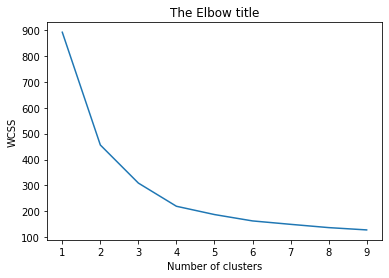

In [36]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [37]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [39]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [40]:
df_kmeans

,KMeans ID,texts
0,0,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
3,3,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...


## Document cleaning and tokenize sentences

In [75]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*'-+/]/g"

specialchar_pattern = re.compile(special_characters)

In [76]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [77]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [78]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [79]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [80]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [199]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'กิน', 'ทาน', 'บาท', 'ผม', 'กก', 'น', 'รีวิว', 'เรา', 'ฉัน', 'นึง', 'าน', 'ส', 'กา', 'ศ']
screening_words = stopwords + removed_words

new_words = {"สตารบัก", 'ไม่อร่อย', 'ปลาร้า', 'บรรยายกาศ', 'อเมซอน', 'หนองมน', 'หัวหิน'}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [200]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [201]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, Macchiato, เป็นประจำ, เด, ArtofCoffe...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ชอบ, 8), (คาเฟ่,..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (อร่อย, 6), (ซอย, 6), (อาหาร..."
2,2,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(อร่อย, 8), (บ้าน, 5), (ร้านกาแฟ, 5), (กาแฟ, ..."
3,3,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."


In [202]:
#show top keywords of each cluster

top_N_words = 15

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('ชอบ', 8), ('คาเฟ่', 6), ('แวะ', 6), ('น่ารัก', 5), ('นั่ง', 5), ('เจอ', 5), ('คน', 4), ('เบเกอรี่', 4), ('พาย', 4), ('วัง', 4), ('แนว', 4), ('กร้าน', 4), ('แถว', 4)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 11), ('อร่อย', 6), ('ซอย', 6), ('อาหาร', 6), ('ราคา', 5), ('สวัสดี', 4), ('เพื่อน', 4), ('ส้มตำ', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('ไร้', 3), ('ยำ', 3), ('รา', 3), ('เก่าแก่', 3)]

Cluster ID : 2

Most common words include : [('อร่อย', 8), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('อาหาร', 4), ('ชอบ', 4), ('ร้านอาหาร', 4), ('มีโอกาส', 3), ('ถนน', 3), ('คิว', 3), ('ครั้งแรก', 3), ('ซื้อ', 3), ('นะคะ', 3), ('เลือก', 3), ('บอ', 3)]

Cluster ID : 3

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('เครื่องดื่ม', 4), ('ร้า', 3), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('แวะ', 2), ('เติม', 2), ('นขา', 2), ('ชาเขียว', 2), ('นิว',

## Display cluster to keywords

In [204]:
df_top = pd.DataFrame(columns=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])

In [205]:
for ind,val in enumerate(df_kmeans['texts_count']): 
 df_top[f'Cluster {ind}'] = val[:15]
df_top

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,"(ร้านกาแฟ, 22)","(ร้านอาหาร, 11)","(อร่อย, 8)","(ชา, 18)"
1,"(กาแฟ, 19)","(อร่อย, 6)","(บ้าน, 5)","(นม, 14)"
2,"(ชอบ, 8)","(ซอย, 6)","(ร้านกาแฟ, 5)","(ไข่มุก, 14)"
3,"(คาเฟ่, 6)","(อาหาร, 6)","(กาแฟ, 5)","(เครื่องดื่ม, 4)"
4,"(แวะ, 6)","(ราคา, 5)","(อาหาร, 4)","(ร้า, 3)"
5,"(น่ารัก, 5)","(สวัสดี, 4)","(ชอบ, 4)","(ตั้งอยู่, 3)"
6,"(นั่ง, 5)","(เพื่อน, 4)","(ร้านอาหาร, 4)","(ลอง, 3)"
7,"(เจอ, 5)","(ส้มตำ, 4)","(มีโอกาส, 3)","(เดิน, 3)"
8,"(คน, 4)","(ไทย, 4)","(ถนน, 3)","(ไต้หวัน, 3)"
9,"(เบเกอรี่, 4)","(แซ่บ, 4)","(คิว, 3)","(ไหม, 2)"
